<a href="https://colab.research.google.com/github/Jeditem/VKCup_2020/blob/master/VKCup_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import itertools
import numpy as np
import pandas as pd
import pandas_profiling as pd_prof
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn.metrics import mean_squared_error
from scipy.stats import lognorm, norm

from lightgbm import LGBMRegressor, plot_importance
from xgboost import XGBRegressor
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
users_df = pd.read_csv(r'/content/gdrive/My Drive/VKCup/users.tsv', sep='\t')
history_df = pd.read_csv(r'/content/gdrive/My Drive/VKCup/history.tsv', sep='\t')
validate_df = pd.read_csv(r'/content/gdrive/My Drive/VKCup/validate.tsv', sep='\t')
answers_df = pd.read_csv(r'/content/gdrive/My Drive/VKCup/validate_answers.tsv', sep='\t')

# Data preparation

In [0]:
X = validate_df.copy()
Y = answers_df.copy()
users_prep = users_df.copy()
history_prep = history_df.copy()
# объединим на время с ответами, чтобы было удобнее сортировать и обрабатывать
X = X.join(Y)

In [0]:
# Сначала сконвертим колонки с площадками и юзерами в листы и возьмем их размеры
X['user_ids'] = X['user_ids'].astype(str).str.split(',')
X['audience_size'] = X['user_ids'].str.len()
X['publishers'] = X['publishers'].astype(str).str.split(',')
X['publishers_amount'] = X['publishers'].str.len()
# Здесь де вычислим продолжительность рекламы
X['ads_duration'] = X['hour_end'] - X['hour_start']

In [0]:
# вычисляем параметры распределения ставок
# вычисляем среднюю цену юзера по его просмотрам
history_for_param = history_prep[(history_prep['cpm'] <=1000)]
param_total=lognorm.fit(history_for_param['cpm'], floc=0)
param_total
users_costs = history_for_param.groupby('user_id')['cpm'].mean()
users_df = users_df.join(users_costs).fillna(0.0)

In [0]:
# По параметрам распределения оценим вероятность, что хоть кто-то за такую цену хоть раз увидит это все
X['proba_one'] = X.apply(lambda row: lognorm.cdf(row['cpm'], *param_total), axis=1)

In [0]:
# теперь вычислим для каждой ставки, среднюю стоимость товарищей, на которых она целится, и разницу
# UPD практика показала, что можно даже не считать вероятность, модельке хватает разницы
def calculate_mean_cpm_by_users (users_list):
    total_cpm = []
    for user in users_list:
        curr_user_cost = users_df.iloc[[int(user)]]['cpm']
        total_cpm.append(curr_user_cost.values[0])
    return np.mean(total_cpm)

In [0]:
%%time
X['mean_cost'] = X.apply(lambda row: calculate_mean_cpm_by_users(row['user_ids']), axis=1)
X['discrepancy'] = X['mean_cost'] - X['cpm']

CPU times: user 7min 45s, sys: 210 ms, total: 7min 45s
Wall time: 7min 45s


In [0]:
# добавим сюда относительную разницу
X['relative_dif'] = X['mean_cost'].div(X['cpm'])

# Model validation

In [0]:
# metric
def get_smoothed_log_mape_column_value(responses_column, answers_column, epsilon):
    return np.abs(np.log(
        (responses_column + epsilon)
        / (answers_column + epsilon)
    )).mean()

def get_smoothed_mean_log_accuracy_ratio(answers, responses, epsilon=0.005):
    log_accuracy_ratio_mean = np.array(
        [
            get_smoothed_log_mape_column_value(responses.at_least_one, answers.at_least_one, epsilon),
            get_smoothed_log_mape_column_value(responses.at_least_two, answers.at_least_two, epsilon),
            get_smoothed_log_mape_column_value(responses.at_least_three, answers.at_least_three, epsilon),
        ]
    ).mean()

    percentage_error = 100 * (np.exp(log_accuracy_ratio_mean) - 1)

    return percentage_error.round(
        decimals=2
    )

так как пока все фичи слабо зависят от времени (ну, кроме часа начала и часа конца), то можно не особо боясь заглянуть в будущее валидировать обычной кросс-валидацией

In [0]:
def standart_cross_validation(X, Y, model, n_folds=20):
    score_list = []
    for i in np.arange(0,n_folds):
        X_train, X_holdout, y_train, y_holdout = train_test_split(X, Y, test_size=0.3,random_state=i)
        model.fit(X_train, y_train)
        results = model.predict(X_holdout)
        result_df = pd.DataFrame(results, columns=['at_least_one','at_least_two','at_least_three'])
        score = get_smoothed_mean_log_accuracy_ratio(y_holdout, result_df)
        score_list.append(score)
    print(f'{np.mean(score_list)} ± {np.std(score_list)}')
    return score_list

In [0]:
 def multilabel_model_cross_validation(X, Y, model, n_folds=20):
    score_list = []
    for i in np.arange(0,n_folds):
        X_train, X_holdout, y_train, y_holdout = train_test_split(X, Y, test_size=0.3,random_state=i)
        model.fit(X_train, y_train['at_least_one'])
        results1 = model.predict(X_holdout).reshape(len(y_holdout), 1)
        model.fit(X_train, y_train['at_least_two'])
        results2 = model.predict(X_holdout).reshape(len(y_holdout), 1)
        model.fit(X_train, y_train['at_least_three'])
        results3 = model.predict(X_holdout).reshape(len(y_holdout), 1)
        results = np.concatenate((results1,results2,results3), axis=1)
        # print(results.shape)
        result_df = pd.DataFrame(results, columns=['at_least_one','at_least_two','at_least_three'])
        score = get_smoothed_mean_log_accuracy_ratio(y_holdout, result_df)
        score_list.append(score)
    print(f'{np.mean(score_list)} ± {np.std(score_list)}')
    return score_list

In [0]:
# Fancy function to plot GridSearch results
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=12)
    ax.grid('on')
    fig = plt.gcf()
    fig.set_size_inches(20, 10)

# Calling Method 
# plot_grid_search(pipe_grid.cv_results_, n_estimators, max_features, 'N Estimators', 'Max Features')

In [0]:
# param search
# Works only for 2d search grid!!!
def custom_search(X, Y, model, param_dict):
    scores_matrix = np.zeros((len(list(param_name.values())[0]), len(list(param_name.values())[1])))
    size = scores_matrix.size
    n = 1
    for i, first_param in enumerate(list(param_name.values())[0]):
        for j, second_param in enumerate(list(param_name.values())[1]):
            curr_params = {list(param_name.keys())[0]: first_param, list(param_name.keys())[1]: second_param}
            # print(f'Current parameters: {curr_params}')
            print(f'Step {n}/{size}')
            model = model.set_params(**curr_params)
            # print(curr_model)
            scores_matrix[i,j] = np.mean(multilabel_model_cross_validation(X, Y, model))
            n += 1
    return scores_matrix

# Baseline

Бейзлайн здесь хитрый - все доли выставляются в нули. На LB идет значение 432,9, при валидации на тестовых данных получаем 448,86 - от них и будем отталкиваться при оценке наших моделей

In [0]:
base_results = np.zeros((1008, 3))
base_result_df = pd.DataFrame(base_results, columns=['at_least_one','at_least_two','at_least_three'])

In [0]:
get_smoothed_mean_log_accuracy_ratio(base_result_df, Y)

445.86

# Linear regression

In [0]:
lin_model = LinearRegression()

In [0]:
X_lin = X.copy()
X_lin = X_lin.drop(columns=['user_ids','publishers', 'at_least_one', 'at_least_two', 'at_least_three'])
X_lin = X_lin.drop(columns=['test'])
# X_lin = X_lin[['cpm', 'ads_duration','proba_discrepancy']]

In [0]:
X_lin

,cpm,hour_start,hour_end,audience_size,publishers_amount,ads_duration,proba_one,mean_cost,discrepancy,proba_discrepancy,relative_dif
0,220.0,1058,1153,1906,2,95,0.788306,201.954843,-18.045157,0.044479,0.917977
1,312.0,1295,1301,1380,2,6,0.885477,160.744132,-151.255868,0.012228,0.515206
2,70.0,1229,1249,888,6,20,0.302258,184.204108,114.204108,0.081019,2.631487
3,240.0,1295,1377,440,2,82,0.816137,204.438568,-35.561432,0.039220,0.851827
4,262.0,752,990,1476,4,238,0.841761,219.125446,-42.874554,0.037076,0.836357
...,...,...,...,...,...,...,...,...,...,...,...
1003,127.0,1095,1154,368,5,59,0.566687,192.748666,65.748666,0.069351,1.517706
1004,90.0,1052,1056,484,2,4,0.409605,187.152288,97.152288,0.077260,2.079470
1005,122.0,1058,1063,704,2,5,0.548431,164.052075,42.052075,0.062685,1.344689
1006,138.0,932,1169,1210,3,237,0.603951,195.746255,57.746255,0.067157,1.418451


In [0]:
standart_cross_validation(X_lin, Y, lin_model)

394.0469999999999 ± 45.57879069260176


[376.18,
 349.66,
 335.5,
 431.88,
 410.81,
 446.25,
 502.63,
 467.48,
 425.15,
 387.65,
 359.37,
 321.21,
 373.01,
 395.27,
 380.87,
 398.37,
 419.03,
 391.03,
 320.56,
 389.03]

# LGBM

In [0]:
param_dict = {'learning_rate': 0.09, 'n_estimators': 30, 'reg_alpha': 1.4}
# param_dict = {'learning_rate': 0.06}

In [0]:
lgbm_model = LGBMRegressor(**param_dict)
# lgbm_model = LGBMRegressor()

In [0]:
lgbm_model

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.09, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=30, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=1.4, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [0]:
X_lgbm = X.copy()
X_lgbm = X_lgbm.drop(columns=['user_ids','publishers', 'discrepancy','at_least_one', 'at_least_two', 'at_least_three'])
X_lgbm = X_lgbm.drop(columns=['test'])
# X_lgbm = X_lgbm[['publishers_amount', 'ads_duration', 'proba_discrepancy']]

In [0]:
X_lgbm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1008 entries, 0 to 1007
Data columns (total 10 columns):
cpm                  1008 non-null float64
hour_start           1008 non-null int64
hour_end             1008 non-null int64
audience_size        1008 non-null int64
publishers_amount    1008 non-null int64
ads_duration         1008 non-null int64
proba_one            1008 non-null float64
mean_cost            1008 non-null float64
proba_discrepancy    1008 non-null float64
relative_dif         1008 non-null float64
dtypes: float64(5), int64(5)
memory usage: 78.9 KB


In [0]:
multilabel_model_cross_validation(X_lgbm, Y, lgbm_model)
# -----без невязки ставка/средняя цена ------
# {'learning_rate': 0.03, 'n_estimators': 50} 348.0975 ± 32.09340678005374
# {'learning_rate': 0.15, 'n_estimators': 14} 348.07750000000004 ± 34.40194483964533
# {'learning_rate': 0.06, 'n_estimators': 30} 347.7605 ± 33.071606776054885
# {'learning_rate': 0.06, 'n_estimators': 30, 'max_depth': 2} 345.8455 ± 34.83766445601656
# {'learning_rate': 0.09, 'n_estimators': 30, 'reg_alpha': 1.4} 342.184 ± 33.72392717344763
# -----с невязкой ставка/средняя цена ------
# {'learning_rate': 0.06, 'n_estimators': 41, 'max_depth':3, 'reg_alpha': 1.4} 340.6245 ± 31.053586020780273
# {'learning_rate': 0.09, 'n_estimators': 30, 'reg_alpha': 1.4} 339.16849999999994 ± 33.25038064067839
# -----с абсолютной и относительной невязкой ставка/средняя цена ------
# {'learning_rate': 0.09, 'n_estimators': 30, 'reg_alpha': 1.4} 339.89850000000007 ± 31.460734777655787 - главное - разброс уменьшился

339.89850000000007 ± 31.460734777655787


[290.82,
 288.34,
 323.37,
 338.23,
 370.31,
 373.81,
 381.95,
 372.2,
 377.37,
 307.08,
 316.63,
 315.27,
 303.39,
 374.3,
 338.81,
 362.47,
 383.22,
 336.64,
 308.22,
 335.54]

In [0]:
lgbm_model.fit(X_lgbm, Y['at_least_one'])

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.06, max_depth=3,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=41, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=1.4, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

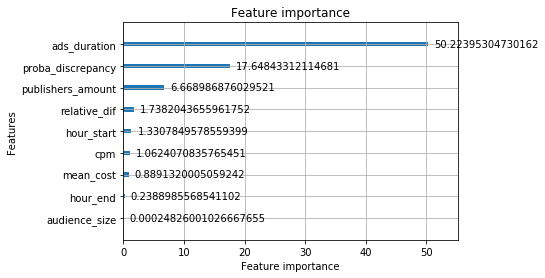

In [0]:
plot_importance(lgbm_model, importance_type ='gain')

In [0]:
%%time
# что-то тюнингом не пробивается 340 никак((
param_name = {'reg_alpha': np.arange(1.0, 2.1, 0.1),'n_estimators': np.arange(30, 81, 5)}
search_scores = custom_search(X_lgbm, Y, lgbm_model, param_name)

Step 1/121
342.68999999999994 ± 30.090461445448124
Step 2/121
341.36949999999996 ± 30.9477363429056
Step 3/121
340.678 ± 31.507593148319014
Step 4/121
340.89 ± 32.093168276130044
Step 5/121
341.1765 ± 32.8441136697278
Step 6/121
341.668 ± 33.45533942437291
Step 7/121
342.82550000000003 ± 34.40982584597022
Step 8/121
344.70450000000005 ± 35.03522362922777
Step 9/121
347.3575 ± 35.92915443967475
Step 10/121
351.12149999999997 ± 37.57191601116451
Step 11/121
355.76050000000004 ± 39.14533260492239
Step 12/121
342.774 ± 30.060314935143303
Step 13/121
341.4325 ± 30.8146064188722
Step 14/121
340.97649999999993 ± 31.432087629522798
Step 15/121
340.83599999999996 ± 31.965966026385
Step 16/121
341.015 ± 32.75529369430231
Step 17/121
341.649 ± 33.57911298709364
Step 18/121
342.7095 ± 34.408608730229126
Step 19/121
344.1715 ± 35.17896733490055
Step 20/121
346.4525 ± 35.5714953122581
Step 21/121
350.18600000000004 ± 37.10543092324896
Step 22/121
354.34350000000006 ± 38.329418633081296
Step 23/121
3

# XGBoost

In [0]:
param_dict = {}

In [0]:
# xgb_model = XGBRegressor(**param_dict)
xgb_model = XGBRegressor(verbosity=0)

In [0]:
X_xgb = X.copy()
X_xgb = X_xgb.drop(columns=['user_ids','publishers', 'discrepancy','at_least_one', 'at_least_two', 'at_least_three'])
X_xgb = X_xgb.drop(columns=['test'])
# X_lgbm = X_lgbm[['publishers_amount', 'ads_duration', 'proba_discrepancy']]

In [0]:
X_xgb.head()

,cpm,hour_start,hour_end,audience_size,publishers_amount,ads_duration,proba_one,mean_cost,proba_discrepancy,relative_dif
0,220.0,1058,1153,1906,2,95,0.788306,201.954843,0.044479,0.917977
1,312.0,1295,1301,1380,2,6,0.885477,160.744132,0.012228,0.515206
2,70.0,1229,1249,888,6,20,0.302258,184.204108,0.081019,2.631487
3,240.0,1295,1377,440,2,82,0.816137,204.438568,0.039220,0.851827
4,262.0,752,990,1476,4,238,0.841761,219.125446,0.037076,0.836357


In [0]:
multilabel_model_cross_validation(X_xgb, Y, xgb_model)
# -----с абсолютной и относительной невязкой ставка/средняя цена ------
# без параметров 412.29499999999996 ± 45.777858130323224

412.29499999999996 ± 45.777858130323224


[313.68,
 333.63,
 394.36,
 405.27,
 468.4,
 506.39,
 468.53,
 408.3,
 476.1,
 376.65,
 387.01,
 405.24,
 386.45,
 437.64,
 410.58,
 423.82,
 452.68,
 416.22,
 380.66,
 394.29]

In [0]:
%%time
param_name = {'learning_rate': np.arange(0.03,0.16,0.03),'n_estimators': np.arange(1, 51, 5)}
search_scores = custom_search(X_xgb, Y, xgb_model, param_name)

Step 1/50
1760.39 ± 214.6279719654454
Step 2/50
1546.2649999999999 ± 188.77260422264666
Step 3/50
1364.5605 ± 166.1140343100185
Step 4/50
1210.7630000000001 ± 146.60262999346227
Step 5/50
1080.5950000000003 ± 129.90806932211717
Step 6/50
970.6020000000001 ± 115.3032874899931
Step 7/50
878.2265000000001 ± 102.81866573122801
Step 8/50
799.9784999999999 ± 91.60745893621328
Step 9/50
733.4409999999999 ± 81.72564676403607
Step 10/50
677.0759999999999 ± 73.13150131099457
Step 11/50
1713.2685000000001 ± 208.97610273126926
Step 12/50
1325.7235 ± 161.15866496329014
Step 13/50
1048.958 ± 125.73281427694202
Step 14/50
853.4305 ± 99.22426817442394
Step 15/50
713.6310000000001 ± 78.73337633430944
Step 16/50
613.1495 ± 63.15068966171312
Step 17/50
539.64 ± 52.35696563018143
Step 18/50
485.09799999999996 ± 44.77909597122299
Step 19/50
445.468 ± 39.42725017040879
Step 20/50
416.6535 ± 35.695855120027595
Step 21/50
1666.225 ± 203.30805919835055
Step 22/50
1141.1470000000002 ± 137.6817144031843
Step 23/

357.3985


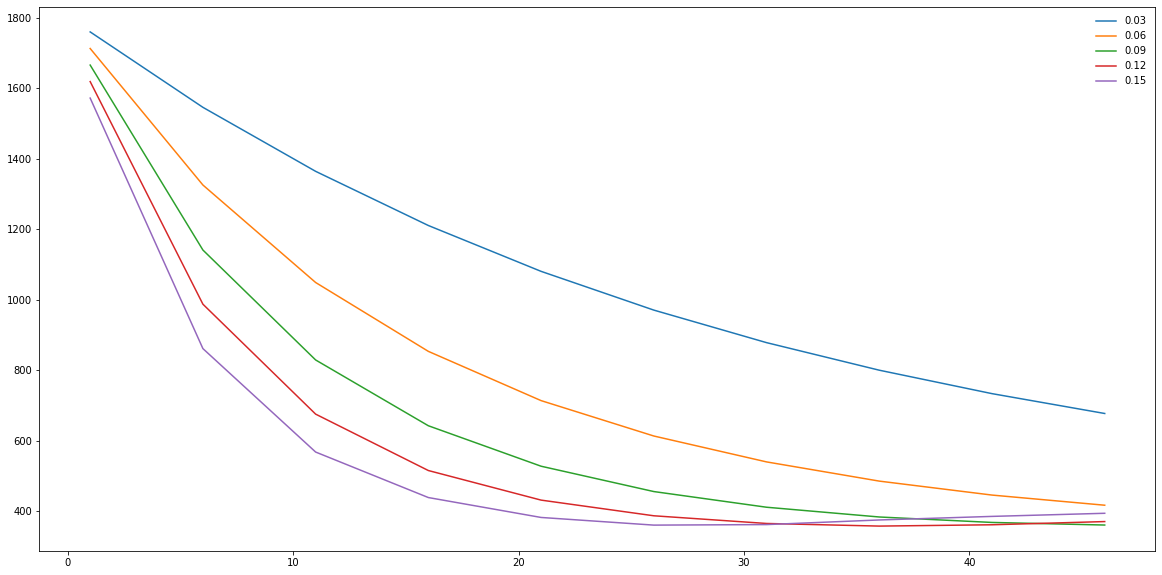

In [0]:
# проверялись параметры XGB
# param_name = {'learning_rate': np.arange(0.03,0.16,0.03),'n_estimators': np.arange(1, 151, 5)}
fig, ax = plt.subplots(1,1)
fig.set_size_inches(20, 10)
for i in range(0,search_scores.shape[0]):
    plt.plot(list(param_name.values())[1],search_scores[i].T, label = list(param_name.values())[0][i])
ax.legend(loc='best', frameon=False)
print(np.min(search_scores))

# Лог поисков параметров

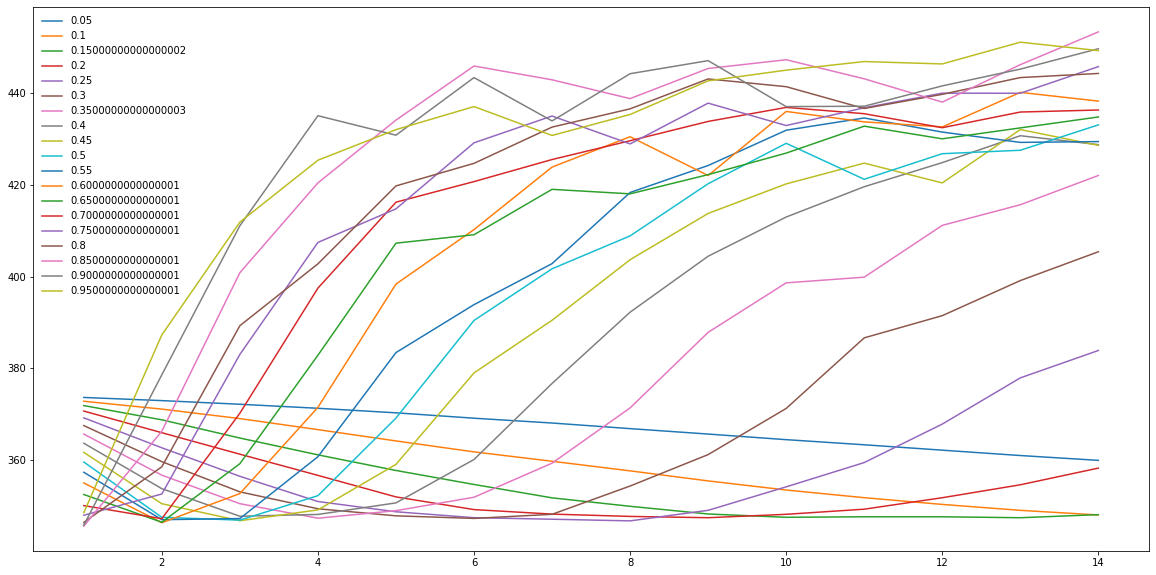

In [0]:
# проверялись параметры lGBM
# param_name = {'learning_rate': np.arange(0.05,1.0,0.05),'n_estimators': np.arange(1,15,1)}
fig, ax = plt.subplots(1,1)
fig.set_size_inches(20, 10)
for i in range(0,search_scores.shape[0]):
    plt.plot(list(param_name.values())[1],search_scores[i].T, label = list(param_name.values())[0][i])
ax.legend(loc='best', frameon=False)

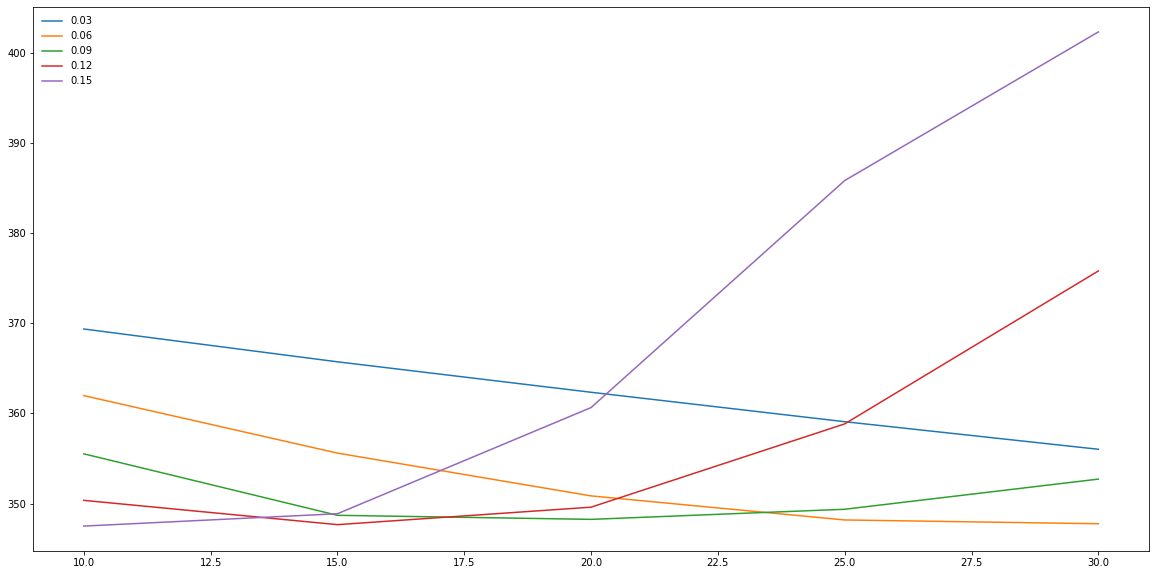

In [0]:
# проверялись параметры lGBM
# param_name = {'learning_rate': np.arange(0.03,0.16,0.03),'n_estimators': np.arange(10,31,5)}
fig, ax = plt.subplots(1,1)
fig.set_size_inches(20, 10)
for i in range(0,search_scores.shape[0]):
    plt.plot(list(param_name.values())[1],search_scores[i].T, label = list(param_name.values())[0][i])
ax.legend(loc='best', frameon=False)

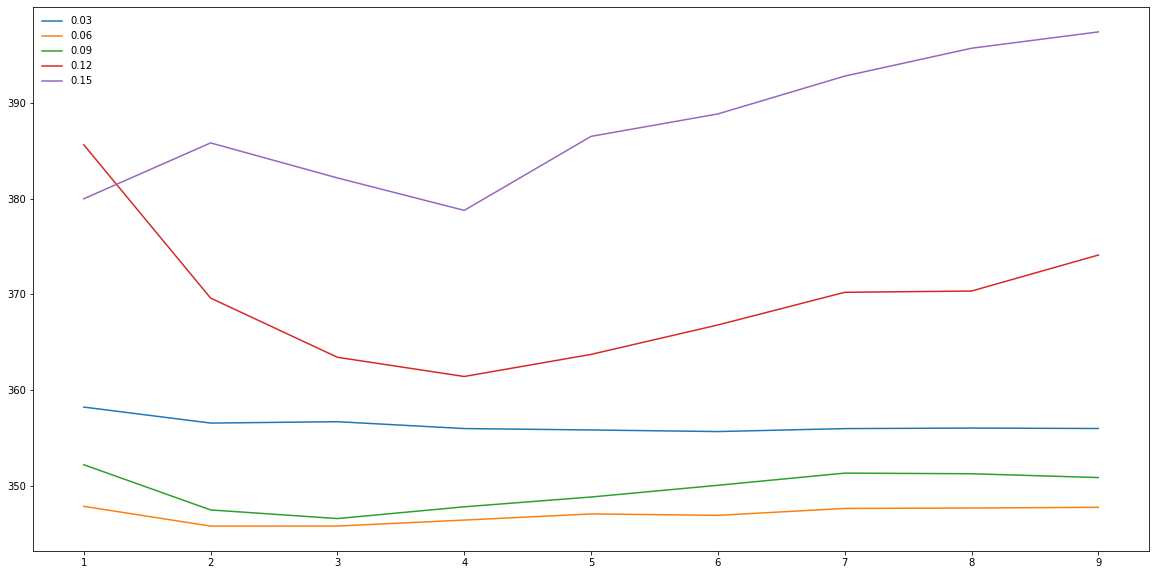

In [0]:
# проверялись параметры lGBM
# param_name = {'learning_rate': np.arange(0.03,0.16,0.03),'max_depth ': np.arange(1,10,1)}
fig, ax = plt.subplots(1,1)
fig.set_size_inches(20, 10)
for i in range(0,search_scores.shape[0]):
    plt.plot(list(param_name.values())[1],search_scores[i].T, label = list(param_name.values())[0][i])
ax.legend(loc='best', frameon=False)

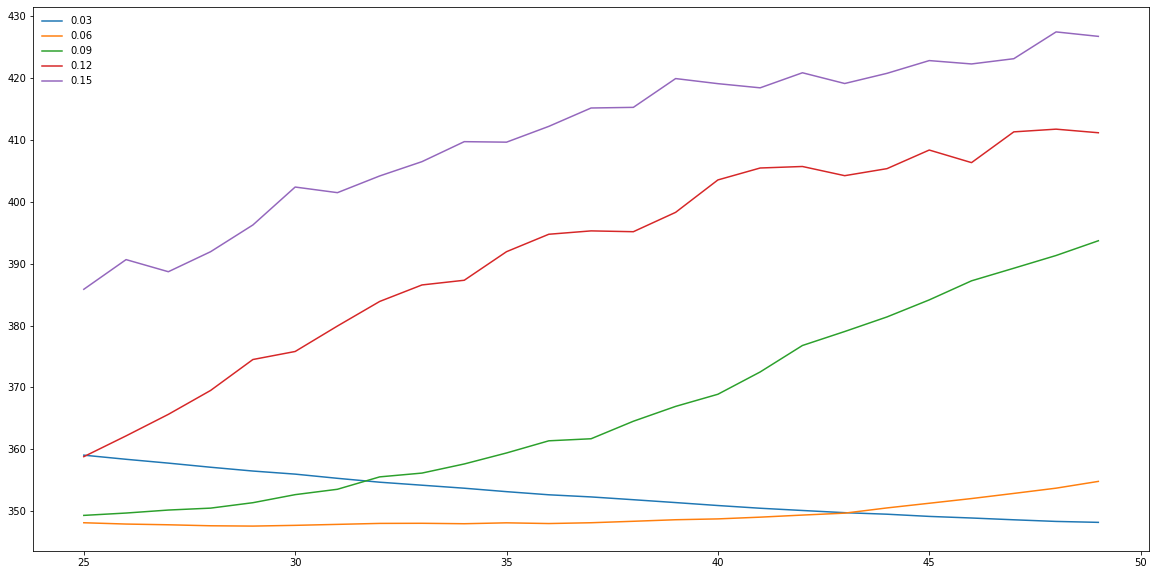

In [0]:
# проверялись параметры lGBM
# param_name = {'learning_rate': np.arange(0.03,0.16,0.03),'n_estimators': np.arange(25,50,1)}
fig, ax = plt.subplots(1,1)
fig.set_size_inches(20, 10)
for i in range(0,search_scores.shape[0]):
    plt.plot(list(param_name.values())[1],search_scores[i].T, label = list(param_name.values())[0][i])
ax.legend(loc='best', frameon=False)

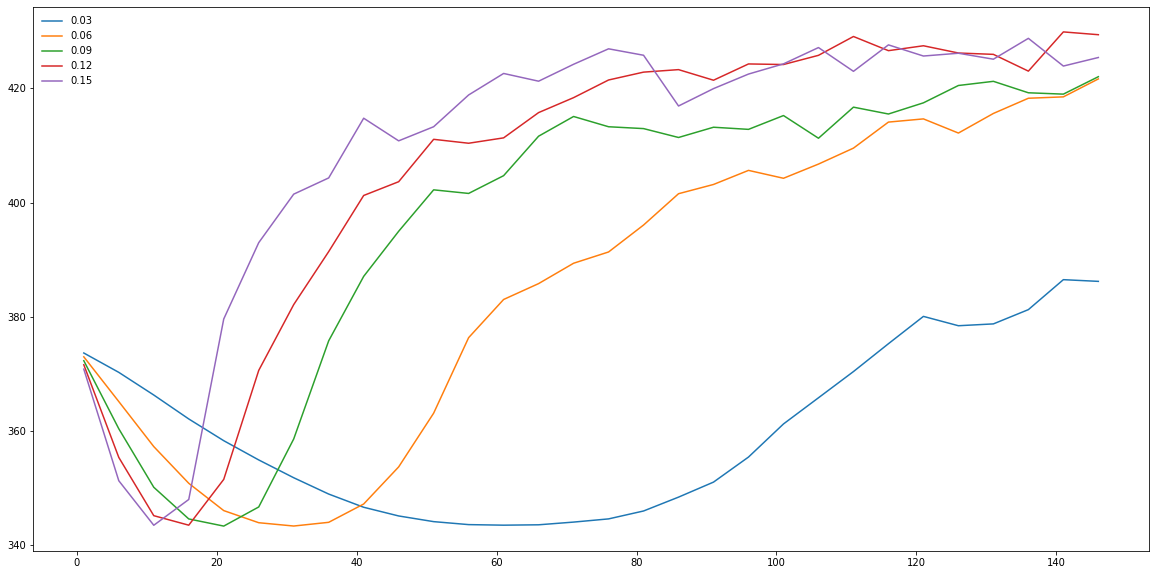

In [0]:
# проверялись параметры lGBM
# param_name = {'learning_rate': np.arange(0.03,0.16,0.03),'n_estimators': np.arange(1, 151, 5)}
fig, ax = plt.subplots(1,1)
fig.set_size_inches(20, 10)
for i in range(0,search_scores.shape[0]):
    plt.plot(list(param_name.values())[1],search_scores[i].T, label = list(param_name.values())[0][i])
ax.legend(loc='best', frameon=False)